In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_GBM = pd.read_csv("Poore_GBM", index_col=0)
Poore_GBM

,g__Cobetia,g__Ammonifex,g__Owenweeksia,g__Haloplasma,g__Desulfosarcina,g__Asaia,g__Parvibaculum,g__Neosynechococcus,g__Zymomonas,g__Kutzneria,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s14192,0.893485,2.203858,1.674120,0.424344,1.372460,1.464566,1.517857,1.734031,-0.420666,2.438608,...,112.0,0.13,1.85,121.9,RNA,E843157C-27A8-4F36-8F07-96A24E8C9771,Primary Tumor Field,EXTERNAL BEAM,2002.0,Dead
s14168,0.180814,0.135872,-0.954348,0.682776,2.751091,1.512538,-1.407964,1.084384,-0.279578,3.235536,...,NaN,0.16,1.90,20.0,DNA,NaN,NaN,NaN,2007.0,Dead
s14197,1.543645,2.854018,2.324280,1.074504,1.842048,2.114726,2.168017,2.384191,0.229494,1.038142,...,40.0,0.13,NaN,46.5,RNA,3A8D2E10-2AB1-40BA-A501-B0A56DADC35C,Primary Tumor Field,EXTERNAL BEAM,2002.0,Dead
s14161,0.997963,2.170523,1.664342,0.570449,-0.332872,1.506755,1.549414,1.798506,-0.405216,0.919969,...,122.0,0.15,1.80,219.7,RNA,E8425728-844D-46E5-9835-EAA9CB3A2EB1,Primary Tumor Field,EXTERNAL BEAM,2009.0,Alive
s14165,1.021629,2.180318,1.635810,0.419256,1.868306,1.526159,1.553676,3.252892,-0.421363,1.839091,...,34.0,0.15,1.80,52.6,RNA,45027352-CD80-448B-AC0F-4FD3173529DA,Primary Tumor Field,EXTERNAL BEAM,2010.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s14113,1.125039,2.549325,2.202670,0.560846,1.890649,2.116887,1.787414,1.931288,0.058256,2.595059,...,70.0,0.15,1.90,98.4,RNA,8190E5D0-A3CA-4451-97DA-1619FC5C20FB,Primary Tumor Field,EXTERNAL BEAM,2007.0,Dead
s14107,2.359550,2.084960,1.555222,0.305446,-2.833901,1.345668,1.398959,1.615133,-0.539564,0.631654,...,NaN,0.17,1.81,123.6,RNA,7450C1EA-8F99-4CF1-9471-F3A344E73358,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive
s14080,0.657392,2.110302,1.562616,0.397289,2.176143,1.338868,1.185277,1.730294,-0.824475,1.898189,...,NaN,0.55,1.79,35.0,RNA,8E82EE4F-FE89-45DC-96EE-E68378F12A75,Primary Tumor Field,EXTERNAL BEAM,2005.0,Dead


In [3]:
class_counts = Poore_GBM['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           382
Blood Derived Normal     71
Recurrent Tumor          36
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = Poore_GBM.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_GBM['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Recurrent Tumor']
Unique values of y: [0 1 2]


In [5]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(1146, 1170)
(1146,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best Score: 0.9576009316770187
Test Set Accuracy: 0.9622093023255814


<Figure size 800x600 with 0 Axes>

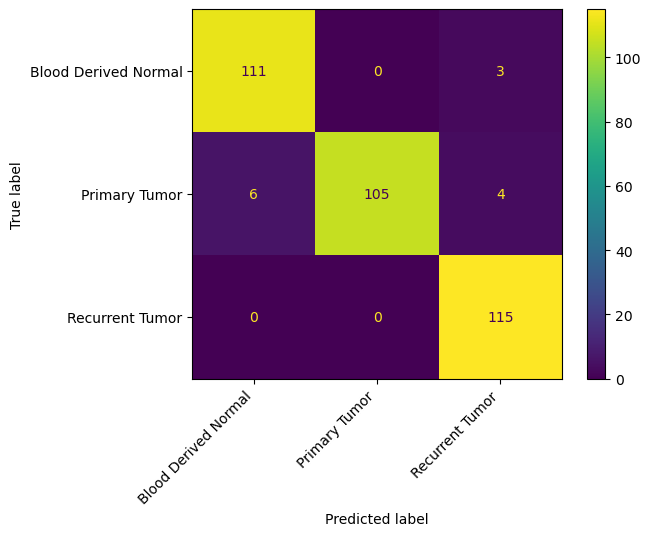

                      precision    recall  f1-score   support

Blood Derived Normal       0.95      0.97      0.96       114
       Primary Tumor       1.00      0.91      0.95       115
     Recurrent Tumor       0.94      1.00      0.97       115

            accuracy                           0.96       344
           macro avg       0.96      0.96      0.96       344
        weighted avg       0.96      0.96      0.96       344



In [6]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Recurrent Tumor'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Blood Derived Normal', 'Primary Tumor', 'Recurrent Tumor'])
print(report)

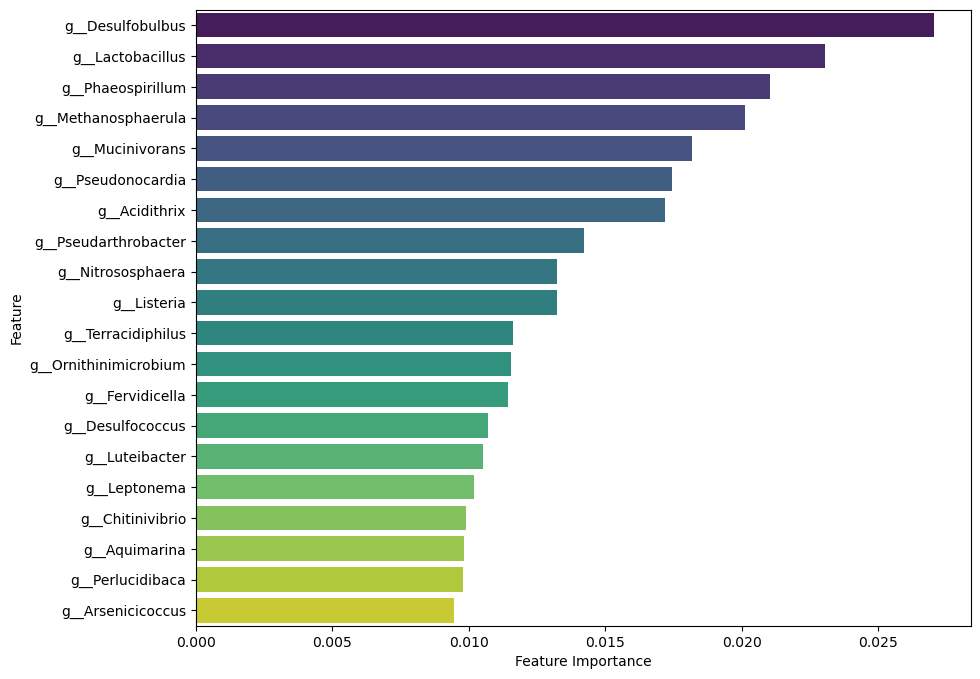

In [7]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

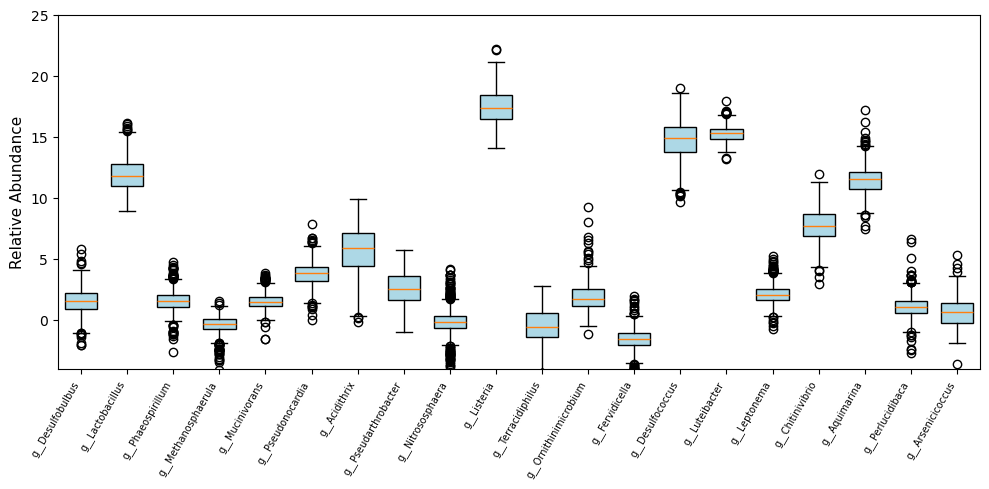

In [11]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 25)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()
plt.show()